In [1]:
import tensorflow as tf
import numpy as np
import cv2
import time
import math
import importlib
import os
from PIL import Image

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from config import FLAGS
import Detector as dt

In [3]:
#FLAGS.DEMO_TYPE = 'D:\\triangle\\deeplearning\\175project\\hand_pose\\test_img' 
print(FLAGS.DEMO_TYPE)

/home/qiaohe/qiao_img


In [4]:
cpm_model = importlib.import_module('models.nets.' + FLAGS.network_def)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)

""" Build network graph
"""
model = cpm_model.CPM_Model()
#     input_size=FLAGS.image_size,
#                             heatmap_size=FLAGS.hmap_size,
#                             stages=FLAGS.total_stages,
#                             joints=FLAGS.total_joints,
#                             img_type=FLAGS.color_channel,
#                             is_training=False)
saver = tf.train.Saver()

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Traning total loss:  is illegal; using Traning_total_loss__ instead.
INFO:tensorflow:Summary name Global learning rate:  is illegal; using Global_learning_rate__ instead.


In [6]:
# print("input_size=" ,FLAGS.input_size,
#                             "\nheatmap_size=", FLAGS.heatmap_size,
#                             "\nstages=", FLAGS.cpm_stages,
#                             "\njoints=", FLAGS.num_of_joints,
#                             "\nimg_type=", FLAGS.color_channel,
#                             "\nis_training=", False)
print("input_size=" ,FLAGS.image_size,
                            "\nheatmap_size=", FLAGS.hmap_size,
                            "\nstages=", FLAGS.total_stages,
                            "\njoints=", FLAGS.total_joints,
                            "\nimg_type=", FLAGS.color_channel,
                            "\nis_training=", False)

input_size= 256 
heatmap_size= 32 
stages= 6 
joints= 21 
img_type= RGB 
is_training= False


In [7]:
""" This is to set up some GPU options for the tensorflow model
"""
output_node = tf.get_default_graph().get_tensor_by_name(name=FLAGS.output_node_names)

device_count = {'GPU': 1} if FLAGS.use_gpu else {'GPU': 0}
sess_config = tf.ConfigProto(device_count=device_count)
sess_config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess_config.gpu_options.allow_growth = True
sess_config.allow_soft_placement = True

In [8]:
def correct_and_draw_hand(full_img, stage_heatmap, crop_img, original_info):
    #original info: ymin, xmin, original length/width
#     global_joint = np.zeros((FLAGS.num_of_joints, 2))
#     local_joint = np.zeros((FLAGS.num_of_joints, 2))
    global_joint = np.zeros((FLAGS.total_joints, 2))
    local_joint = np.zeros((FLAGS.total_joints, 2))

    mean_response_val = 0.0

    # Plot joint colors
    for joint_num in range(FLAGS.total_joints):
        #this takes the last heatmap
        tmp_heatmap = stage_heatmap[:, :, joint_num]

        #find which position have the largest possibiility to be this joint, and rewrite in form of length-2 list
        joint_coord = np.unravel_index(np.argmax(tmp_heatmap),
                                       (FLAGS.image_size, FLAGS.image_size))
        #for each joint, add its highest(also the taken) score to total response
        mean_response_val += tmp_heatmap[joint_coord[0], joint_coord[1]]
        joint_coord = np.array(joint_coord).astype(np.float32)

        local_joint[joint_num, :] = joint_coord

        # Resize back
        joint_coord *= original_info[2] / FLAGS.image_size

        joint_coord[0] += original_info[0]
        joint_coord[1] += original_info[1]
        global_joint[joint_num, :] = joint_coord


    #if we feel like it fails, then we will don't place hand on the screen
    if mean_response_val >= 1:
        draw_hand(full_img, global_joint)
        draw_hand(crop_img, local_joint)
        cv2.putText(full_img, 'Response: {:<.3f}'.format(mean_response_val),
                    org=(original_info[1], original_info[0]), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))
    
    #we put response on crop image, and original image
    cv2.putText(crop_img, 'Response: {:<.3f}'.format(mean_response_val),
                org=(20, 20), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))


In [9]:
#draw hand points and circles on the canvas
def draw_hand(canvas, joint): 
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(joint)):
        cv2.circle(canvas, (int(joint[i][1]),int(joint[i][0])), 4, FLAGS.joint_color_code[i], thickness=-1)
    for edge in FLAGS.limbs:
        u,v = edge
        cv2.line(canvas,(int(joint[u][1]),int(joint[u][0])),(int(joint[v][1]),int(joint[v][0])),FLAGS.joint_color_code[v],3)

def normalize_and_centralize_img(img):
    norm_img = img / 256.0 - 0.5
    #expand_dims expand the dimension ,axis = 0 means new_img[0] is the original
    #[[1,2],[3,4]] ==axis0==> [[[1,2],[3,4]]]
    #[[1,2],[3,4]] ==axis1==> [[[1,2]],[[3,4]]]
    #[[1,2],[3,4]] ==axis2==> [[[1],[2]],[[3],[4]]]
    return np.expand_dims(norm_img, axis=0)

In [10]:
def predict_image(padding, position=None):
    test_img = []
    img_name = []
    if FLAGS.DEMO_TYPE.endswith(('png', 'jpg')):
        test_img.append(cv2.imread(FLAGS.DEMO_TYPE))
        img_name.append(FLAGS.DEMO_TYPE)
    else:
        file_list = os.listdir(FLAGS.DEMO_TYPE)
        if position!= None:
            file_list = file_list[position[0]:position[1]]

        for img in file_list:
            test_img.append(cv2.imread(os.path.join(FLAGS.DEMO_TYPE, img)))
            img_name.append(os.path.join(FLAGS.DEMO_TYPE, img))
    tt = time.time()
    boxes = dt.bounding_box_from_folder(FLAGS.DEMO_TYPE, padding, position)
    print("Phase 1: ", time.time() - tt)

    tmp_img_list = []
    for index, b_box in enumerate(boxes):
        t0 = time.time()
        bb_img = []
        bb_img_resize = []
        original_info = [] #so that can be recovered from original size and position, with order: ymin, xmin, original length/width
        if b_box != []: 
            bb_box = b_box[0]
            bb_img.append(np.copy(test_img[index][bb_box[1]:bb_box[3],bb_box[0]:bb_box[2],:]))
            original_info.append([bb_box[1], bb_box[0], bb_img[0].shape[0]])
            if len(b_box) > 1: 
                bb_box = b_box[1]
                bb_img.append(np.copy(test_img[index][bb_box[1]:bb_box[3],bb_box[0]:bb_box[2],:])) 
                original_info.append([bb_box[1], bb_box[0], bb_img[1].shape[0]])

        # this is useless, because it already forces to input size
        for i in range(len(bb_img)):
            bb_img[i] = cv2.resize(bb_img[i], (FLAGS.image_size, FLAGS.image_size))
            bb_img_resize.append(normalize_and_centralize_img(bb_img[i]))

            t1 = time.time()

            #current_heatmap is the output after going through the last layer
            #input_images is a placeholder matrix for iiamge size
            # FIXME: I don't know what exactly does this sess run with? the two arguments?
            #predict_heatmap.shape = (1,32,32,22) 
            #stage_heatmap_np.shape = (1,32,32,22), it seems like, for stage_heatmap, each of the 1*32*32 is something same, a 22 length-array
            #predict_heatmap, 
            stage_heatmap_np = sess.run(
                #[model.current_heatmap,
                                                          output_node,
                                                          #],
                                                         feed_dict={model.images: bb_img_resize[i]}
                                                         )
            #frame per second
            print('fps: %.2f' % (1 / (time.time() - t1)))

            correct_and_draw_hand(test_img[index],
                                  cv2.resize(stage_heatmap_np[0], (FLAGS.image_size, FLAGS.image_size)),
                                  bb_img[i], original_info[i])

        # Show visualized image
        '''if len(bb_img) > 0:
            cv2.imshow(img_name[index] + '-1', bb_img[0].astype(np.uint8))
            if len(bb_img) > 1:
                cv2.imshow(img_name[index] + '-2', bb_img[1].astype(np.uint8))
            #cv2.waitKey(0)
        else:
            null_img = np.zeros((FLAGS.image_size, FLAGS.image_size, 3))
            cv2.imshow(img_name[index] + ': not found', null_img.astype(np.uint8))
            #cv2.waitKey(0)'''
        tmp_img = cv2.resize(test_img[index], (1280, 720))      
        #cv2.imshow(img_name[index] + '-0', tmp_img.astype(np.uint8))
        tmp_img_list.append(tmp_img)
        print("Total time for" + str(index) + ": " +str(time.time() - t0))
    return tmp_img_list

In [11]:
#FLAGS.pretrained_model = 'cpm_model-4000'

In [12]:
# FIXME: should merge together, so that lib will not be imported twice, and that speed will be accelerated
# additionally, there seems to be a shift problem
with tf.Session(config=sess_config) as sess:

    model_path_suffix = os.path.join(
        #FLAGS.network_def,
                                     #'input_{}_output_{}'.format(FLAGS.image_size, FLAGS.hmap_size),
                                     #'joints_{}'.format(FLAGS.total_joints),
                                     'stages_{}'.format(FLAGS.total_stages),
                                     'init_{}_rate_{}_step_{}'.format(FLAGS.lr, FLAGS.l_decay_rate,
                                                                      FLAGS.l_decay_step)
                                     )
    model_save_dir = os.path.join('models',
                                  'weights',
                                  model_path_suffix)
    print('Load model from [{}]'.format(os.path.join(model_save_dir, FLAGS.pretrained_model)))

    # if the model is a pkl file, then load it, else just restore the pretrained cpm_hand by default
    # by here we can see the loading weight structure
#     if FLAGS.model_path.endswith('pkl'):
#         model.load_weights_from_file(FLAGS.model_path, sess, False)
#     else:
        #saver.restore(sess, 'models/weights/cpm_hand')
    if FLAGS.pretrained_model != '':
        saver.restore(sess, os.path.join(model_save_dir, FLAGS.pretrained_model))

    # Check weights, this seems to be the part that print out weights
#     for variable in tf.global_variables():
#         with tf.variable_scope('', reuse=True):
#             #this is becuase each layer variable has ':0' inside its name
#             var = tf.get_variable(variable.name.split(':0')[0])
#             print(variable.name, np.mean(sess.run(var)))

        
    t1 = time.time()
    print("Prediction process starts...")
    #we assume they are all images, either folder or single image file
    #if FLAGS.DEMO_TYPE.endswith(('png', 'jpg')): 
    predictions = predict_image(30, None)
    #else:
        #for img in (os.listdir(FLAGS.DEMO_TYPE))[1002:1007]:
            #predict_one_image(img, 30)
    print(time.time() - t1)
    #cv2.waitKey(0)

Load model from [models/weights/stages_6/init_0.0005_rate_0.5_step_10000/cpm_model-24000]
INFO:tensorflow:Restoring parameters from models/weights/stages_6/init_0.0005_rate_0.5_step_10000/cpm_model-24000
Prediction process starts...
Phase 1:  43.893834352493286
fps: 1.55
fps: 5.24
Total time for0: 0.8571915626525879
fps: 5.71
Total time for1: 0.18639373779296875
fps: 5.86
fps: 5.94
Total time for2: 0.35819149017333984
fps: 5.89
fps: 5.94
Total time for3: 0.35648488998413086
fps: 5.94
fps: 5.95
Total time for4: 0.35407042503356934
fps: 5.94
fps: 5.91
Total time for5: 0.35724639892578125
fps: 5.94
fps: 5.92
Total time for6: 0.3556225299835205
fps: 5.93
fps: 5.92
Total time for7: 0.356447696685791
fps: 5.93
fps: 5.91
Total time for8: 0.35608386993408203
Total time for9: 0.0008907318115234375
fps: 5.93
fps: 5.92
Total time for10: 0.35570192337036133
fps: 5.95
fps: 5.94
Total time for11: 0.3544270992279053
fps: 5.90
fps: 5.93
Total time for12: 0.3567795753479004
fps: 5.93
fps: 5.93
Total ti

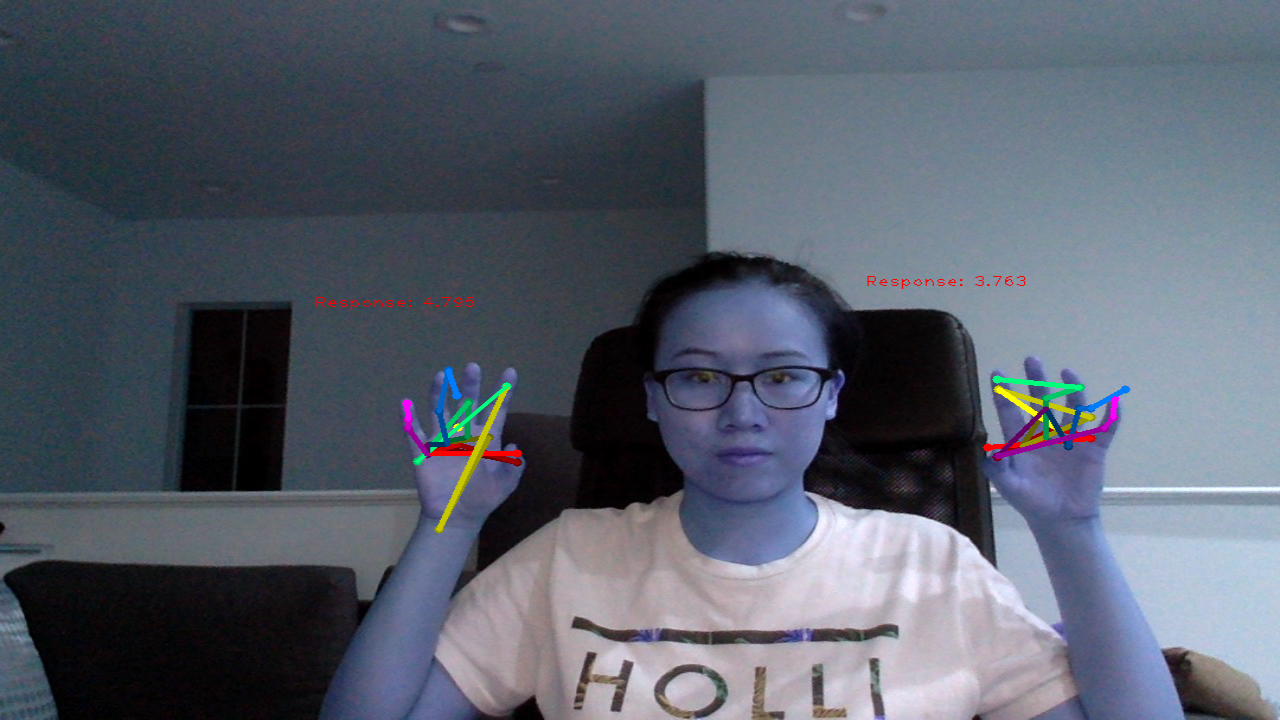

In [16]:
# need to manually change the index, because cv2 on GCP cannot ue imshow, thus only use Image in matplotlib
Image.fromarray(predictions[10]) #1 30

In [14]:
for idx, img in enumerate(predictions): #0 18 19 1 -20 21
    cv2.imwrite("/home/qiaohe/convolutional-pose-machines-tensorflow/prediction_img/stage6itr4000/" + str(idx) + "_.jpg", img)

In [15]:
#store_predict_heatmap = predict_heatmap
#store_stage_heatmap_np = stage_heatmap_np
print(store_predict_heatmap.shape, store_stage_heatmap_np.shape)

NameError: name 'store_predict_heatmap' is not defined

In [ ]:
# this is to show what is inside these two

tmp = np.zeros((32, 32))
tmp2 = np.zeros((32, 32))
enumerater = np.array(range(22))[21:]

for i in enumerater:
    tmp += 43000 * store_predict_heatmap[0,:,:,i]
    tmp2 += 43000 * store_stage_heatmap_np[0,:,:,i]
cv2.imshow('', tmp.astype(np.uint8))
cv2.imshow('2', tmp2.astype(np.uint8))
cv2.waitKey(0)

In [ ]:
def correct_and_draw_hand(full_img, stage_heatmap_np, crop_img, original_info):
#     global_joint = np.zeros((FLAGS.total_joints, 2))
#     local_joint = np.zeros((FLAGS.total_joints, 2))

#     mean_response_val = 0.0

#     # Plot joint colors
#     for joint_num in range(FLAGS.total_joints):
#         #this takes the last heatmap
#         tmp_heatmap = stage_heatmap_np[:, :, joint_num]

#         #find which position have the largest possibiility to be this joint, and rewrite in form of length-2 list
#         joint_coord = np.unravel_index(np.argmax(tmp_heatmap),
#                                        (FLAGS.image_size, FLAGS.image_size))
#         #for each joint, add its highest(also the taken) score to total response
#         mean_response_val += tmp_heatmap[joint_coord[0], joint_coord[1]]
#         joint_coord = np.array(joint_coord).astype(np.float32)

#         local_joint[joint_num, :] = joint_coord

#         # Resize back
#         joint_coord *= original_info[2] / FLAGS.image_size

#         joint_coord[0] += original_info[0]
#         joint_coord[1] += original_info[1]
#         global_joint[joint_num, :] = joint_coord

#     #if we feel like it fails, then we will just place a default hand on the screen
#     if mean_response_val >= 1:
#         draw_hand(full_img, global_joint)
#         draw_hand(crop_img, local_joint)
#         cv2.putText(full_img, 'Response: {:<.3f}'.format(mean_response_val),
#                     org=(original_info[1], original_info[0]), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))
    
#     #we put response on crop image, and original image
#     cv2.putText(crop_img, 'Response: {:<.3f}'.format(mean_response_val),
#                 org=(20, 20), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))

#     #if we feel like it fails, then we will just place a default hand on the screen
#     draw_hand(full_img, global_joint, mean_response_val < 1)
#     draw_hand(crop_img, local_joint, mean_response_val < 1)
    
#     #we put response on crop image, and original image
#     cv2.putText(crop_img, 'Response: {:<.3f}'.format(mean_response_val),
#                 org=(20, 20), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))
#     cv2.putText(full_img, 'Response: {:<.3f}'.format(mean_response_val),
#                 org=(original_info[1], original_info[0]), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))